<a href="https://colab.research.google.com/github/marcelounb/BB/blob/master/ia_mobile_TF_many_categories_final6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Dropout

# For Tokenizing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# For N-grams
from keras.preprocessing import text

# Abrindo o arquivo com todo o Dataset para treinamento

In [3]:
path = "/content/fulldataset.xlsx"

In [4]:
dataset = pd.read_excel(path, sheet_name=0, header=0, dtype={'score': np.int32})

dataset[dataset.columns[3]] = dataset[dataset.columns[3]].fillna('não se aplica')  # retirando os valores nulos

responsavel       = dataset[dataset.columns[0]].tolist()   # Responsável
natureza          = dataset[dataset.columns[1]].tolist()   # Natureza
classificacao     = dataset[dataset.columns[2]].tolist()   # Classificação
produtos_servicos = dataset[dataset.columns[3]].tolist()   # Produtos/Serviços
detalhamento      = dataset[dataset.columns[4]].tolist()   # Detalhamento
review            = dataset[dataset.columns[15]].tolist()  # review
score             = dataset[dataset.columns[16]].tolist()  # score

In [5]:
print(list(dataset.columns))

['Responsável', 'Natureza', 'Classificação', 'Produtos/Serviços', 'Detalhamento', 'Descrição do Problema', 'Produtos/Serviços 2', 'Detalhamento 2', 'Descrição do Problema 2', 'Produtos/Serviços 3', 'Detalhamento 3', 'Descrição do Problema 3', 'id', 'userName', 'userImage', 'review', 'score', 'thumbsUpCount', 'appVersion', 'date', 'reply', 'replyDate']


# Reduzindo o texto (retirando artigos, pontuacao e conjuncao 'e') - review_reduzida

In [6]:
def reduzir_texto(frases):
  frase = ''
  for item in frases.lower().split():
    if item not in ['a', 'o', 'as', 'os', 'da', 'do', 'das', 'dos', 'e', 'no', 'na', 'em', 'i']:  # retira os artigos e conjuncao 'e'
      if item[-1] in ['.', ',', '!', ';' ]:
        frase +=str(item[0:-1])+' '  # retira pontuacao
      else:
        frase +=str(item)+' '
  return frase[:-1]

In [7]:
def reduzir_review(review):
  review_reduzida = []
  for item in review:
    review_reduzida.append(reduzir_texto(item))
  print(review[0:5])
  print(review_reduzida[0:5])
  return review_reduzida

In [8]:
review_reduzida = reduzir_review(review)

['Excelente', 'Muito bom', 'Não estou conseguindo fazer um cartão de crédito para mim Eu só quero Aff já tentei várias vezes fazer o cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri o aplicativo para ver se foi aprovado , Táva mandando fazer tudo dinovo', 'Por mais que eu tente não consigo desbloquear o app para transferências', 'Bom aplicativo eu gosto']
['excelente', 'muito bom', 'não estou conseguindo fazer um cartão de crédito para mim eu só quero aff já tentei várias vezes fazer cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri aplicativo para ver se foi aprovado  táva mandando fazer tudo dinovo', 'por mais que eu tente não consigo desbloquear app para transferências', 'bom aplicativo eu gosto']


# Separando as bases de treinamento e de testes
Utilize review ou review_reduzida


In [9]:
def dataset_split(dataset_name, training_size):
  return dataset_name[0:training_size], dataset_name[training_size:]

training_size = int(len(review) * 0.8)  # Separate out the sentences and labels into training and test sets

training_sentences, testing_sentences = dataset_split(review, training_size)  # Utilize review ou review_reduzida
training_labels, testing_labels = dataset_split(classificacao, training_size)  # Aqui - Dataset Escolhido
training_score,  testing_score = dataset_split(score, training_size)

In [10]:
def acrescentando_dimensionalidade(listagem):
  # Pega uma lista do tipo:[1, 1, 1, 1, 1, 1, 1, 1, 1, 1] e transforma em [[1], [1], [1], [1], [1], [1], [1], [1], [1], [1]]
  # Aqui utilizamos para acrescentar uma dimensionalidade para o campo Score 
  return [[item] for item in listagem]

In [11]:
training_score = acrescentando_dimensionalidade(training_score)  # Acrescentando dimensionalidade a coluna Score
testing_score = acrescentando_dimensionalidade(testing_score)    # Acrescentando dimensionalidade a coluna Score

In [12]:
# Tokenizing classificacao
tokenizer = Tokenizer(split='@', filters='@')  # Não categoriza novas palavras por causa de espaço ou caracteres especiais
tokenizer.fit_on_texts(classificacao)  # Aqui - Dataset Escolhido
word_index = tokenizer.word_index
print(word_index)
prediction_classes = word_index
reversed_prediction_classes = {value : key[0].upper() + key[1:] for (key, value) in prediction_classes.items()}
print(reversed_prediction_classes)

{'elogio': 1, 'reclamação': 2, 'crítica': 3, 'neutra': 4, 'dúvida': 5, 'sugestão': 6, 'resposta': 7, 'solicitação': 8}
{1: 'Elogio', 2: 'Reclamação', 3: 'Crítica', 4: 'Neutra', 5: 'Dúvida', 6: 'Sugestão', 7: 'Resposta', 8: 'Solicitação'}


In [13]:
print('word_index:', len(word_index))
tamanho_classes = len(word_index)+1
print('tamanho_classes:', tamanho_classes)

word_index: 8
tamanho_classes: 9


In [14]:
def transforming_labels(lista):
  # Retorna o numero inteiro referente ao Label - ex: training_labels[0:3] = ['Elogio', 'Elogio', 'Reclamação'] vai retornar [1, 1, 2]
  return [word_index.get(item.lower()) for item in lista]

In [15]:
training_labels = transforming_labels(training_labels)
testing_labels = transforming_labels(testing_labels)

In [16]:
print(training_sentences[0:5])
print(training_labels[0:10], testing_labels[0:10])

['Excelente', 'Muito bom', 'Não estou conseguindo fazer um cartão de crédito para mim Eu só quero Aff já tentei várias vezes fazer o cartão quando eu fui fazer mandou esperar treis dias aí quando eu fui abri o aplicativo para ver se foi aprovado , Táva mandando fazer tudo dinovo', 'Por mais que eu tente não consigo desbloquear o app para transferências', 'Bom aplicativo eu gosto']
[1, 1, 2, 2, 1, 2, 2, 2, 2, 2] [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [17]:
# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)
training_labels_final

array([1, 1, 2, ..., 1, 1, 1])

# Tokenize the dataset
Tokenize the dataset

In [18]:
# Tokenizing values
vocab_size = 4000
embedding_dim = 128
max_length = 150
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
sequences = tokenizer.texts_to_sequences(training_sentences)
word_index = tokenizer.word_index

N-grams (bigrams or trigrams)

In [19]:
def create_ngram_set(input_list, ngram_value=2):
    """Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]"""

    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]"""
    
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [20]:
# N-grams values - Configura o uso de Ngrams:: 1 - Uma palavra (unigrama), 2 - Duas palavras (bigrama)
NGRAN_RANGE = 1

In [21]:
if NGRAN_RANGE > 1:
    ngram_set = set()
    for input_list in sequences:
        for i in range(2, NGRAN_RANGE + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)
    
    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.        
    token_indice = {v: k + vocab_size for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}
    
    # Update vocab_size
    vocab_size = np.max(list(indice_token.keys())) + 1
    print('Update vocab_size %d' % vocab_size)
    
    # Augument sequences with the new features
    sequences = add_ngram(sequences, token_indice, NGRAN_RANGE)
    print(len(sequences), 'sequences')
    print('Average train sequence length: %d' % np.mean(list(map(len, sequences))))

Padding

In [22]:
trunc_type='post'
padding_type='post'

padded = pad_sequences(sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)  #review de treinamento com padding
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, padding=padding_type, truncating=trunc_type)  #review de treinamento com padding

In [23]:
print(padded.shape, testing_padded.shape)
print(padded[0], '\n', training_score[0:4])

(67164, 150) (16791, 150)
[13  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0] 
 [[1], [1], [1], [1]]


In [24]:
training_score = np.asarray(training_score)
testing_score = np.asarray(testing_score)

Unindo o Dataset Score ao Dataset_escolhido (Natureza, Produto e Serviço ou Classificação)

In [25]:
padded2 = np.append(training_score, padded, axis=1)
testing_padded2 = np.append(testing_score, testing_padded, axis=1)

# Review a Sequence
Let's quickly take a look at one of the padded sequences to ensure everything above worked appropriately.

In [26]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, 'x') for i in text])

print(decode_review(padded[0]))
print(training_sentences[0])

excelente x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x
Excelente


# Train a Basic Sentiment Model with Embeddings

In [27]:
max_length +=1  # Somando 1 do Score

In [28]:
# fix random seed for reproducibility 
seed = 7 
np.random.seed(seed)

In [29]:
# Build a basic sentiment network
# Note the embedding layer is first, and the output is a sparse categorical from classes
def baseline_model():
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
  model.add(Flatten())
  model.add(Dense(2001, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(501, activation='relu'))
  model.add(Dense(51, activation='relu'))
  model.add(Dense(tamanho_classes, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'] )
  model.summary()
  return model

In [30]:
# Build a basic sentiment network
# Note the embedding layer is first, and the output is a sparse categorical from classes
def baseline_model2():
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
  model.add(Flatten())
  model.add(Dense(501, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(251, activation='relu'))
  model.add(Dense(tamanho_classes, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'] )
  model.summary()
  return model

In [31]:
model = baseline_model2()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 151, 128)          512000    
_________________________________________________________________
flatten (Flatten)            (None, 19328)             0         
_________________________________________________________________
dense (Dense)                (None, 501)               9683829   
_________________________________________________________________
dropout (Dropout)            (None, 501)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 251)               126002    
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 2268      
Total params: 10,324,099
Trainable params: 10,324,099
Non-trainable params: 0
____________________________________________

In [32]:
num_epochs = 2
hist = model.fit(padded2, training_labels_final, epochs=num_epochs, validation_data=(testing_padded2, testing_labels_final))

Epoch 1/2
2099/2099 [==============================] - 21s 10ms/step - loss: 0.1886 - accuracy: 0.9448 - val_loss: 0.1797 - val_accuracy: 0.9485
Epoch 2/2
2099/2099 [==============================] - 21s 10ms/step - loss: 0.1175 - accuracy: 0.9621 - val_loss: 0.1874 - val_accuracy: 0.9489


In [33]:
scores = model.evaluate(testing_padded2, testing_labels_final, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Baseline Error: 5.11%


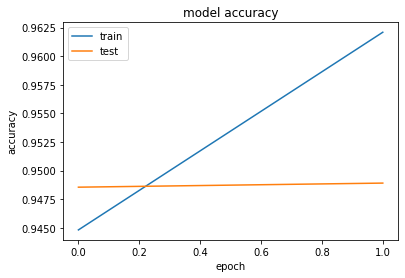

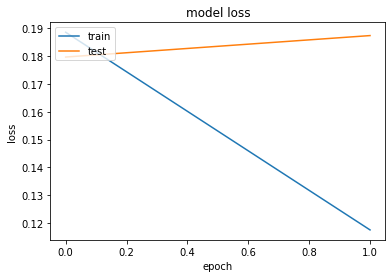

In [34]:
plt.plot(hist.history[ 'accuracy' ])
plt.plot(hist.history[ 'val_accuracy' ])
plt.title( 'model accuracy' )
plt.ylabel( 'accuracy')
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper left' )
plt.show()
# summarize history for loss
plt.plot(hist.history[ 'loss' ])
plt.plot(hist.history[ 'val_loss' ])
plt.title( 'model loss' )
plt.ylabel( 'loss' )
plt.xlabel( 'epoch' )
plt.legend([ 'train' , 'test' ], loc= 'upper left' )
plt.show()

# Novas Predições:

In [35]:
path = "/content/arquivo_novo.xlsx"

In [36]:
dataset = pd.read_excel(path, sheet_name=0, header=0, dtype={'score': np.int32})

responsavel       = dataset[dataset.columns[0]].tolist()   # Responsável
natureza          = dataset[dataset.columns[1]].tolist()   # Natureza
classificacao     = dataset[dataset.columns[2]].tolist()   # Classificação
produtos_servicos = dataset[dataset.columns[3]].tolist()   # Produtos/Serviços
detalhamento      = dataset[dataset.columns[4]].tolist()   # Detalhamento
review            = dataset[dataset.columns[15]].tolist()  # review
score             = dataset[dataset.columns[16]].tolist()  # score

In [37]:
# Use the model to predict a review   
# new_reviews = reduzir_review(review)  # Utilize review ou review_reduzida
new_reviews = review

max_length = 150
# Create the sequences
new_sequences = tokenizer.texts_to_sequences(new_reviews)

Codificando a nova sequencia com base nos Ngrams já mapeados

In [38]:
if NGRAN_RANGE > 1:
  temp_list_final = []
  for item in new_sequences:
    # print(item)
    temp_list, temp_list2 = [], []
    for each in item:
      # print('--', each)
      if len(temp_list)==0:
        primeiro_item = each  # Primeira vez que passa
        temp_list.append(each)
      else:
        tupla = (primeiro_item, each)
        if token_indice.get(tupla) is not None:
          temp_list2.append(token_indice.get(tupla))
        temp_list.append(each)
        primeiro_item = each
    temp_list = temp_list + temp_list2
    temp_list_final.append(temp_list)
    # print(temp_list)
  print(temp_list_final)
  new_sequences = temp_list_final

In [39]:
score = np.asarray(acrescentando_dimensionalidade(score))  # Acrescentando dimensionalidade no score e transformando-o em np array
predict_padded = pad_sequences(new_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
predict_padded2 = np.append(score, predict_padded, axis=1)  # Unindo os DataFrames [score]+[coluna escolhida]

In [40]:
print('\n Exemplo de nova prediçao\n')              

classes = model.predict(predict_padded2)
print(new_reviews[17])
print(classes[15:17])


 Exemplo de nova prediçao

Ótima
[[4.3477718e-26 9.9999976e-01 1.4655242e-08 2.1974921e-08 1.5732674e-07
  2.4801400e-12 3.6959233e-10 2.8091561e-08 4.0199304e-17]
 [8.6525065e-24 9.9999762e-01 9.9107103e-07 1.0733113e-06 2.9681391e-07
  2.6599247e-11 1.4872943e-08 2.3847360e-08 9.6770878e-16]]


In [41]:
classes_list = classes.tolist()
print(reversed_prediction_classes, '\n', reversed_prediction_classes[2] )
lista_predicao = [reversed_prediction_classes[item.index(max(item))] for item in classes_list]  # Pega a classe mais provavel da lista avaliada pelo modelo
print(lista_predicao[5])

{1: 'Elogio', 2: 'Reclamação', 3: 'Crítica', 4: 'Neutra', 5: 'Dúvida', 6: 'Sugestão', 7: 'Resposta', 8: 'Solicitação'} 
 Reclamação
Elogio


In [42]:
dataset[dataset.columns[2]] = lista_predicao  # Aqui - Dataset Escolhido
dataset.head(3)

,Responsável,Natureza,Classificação,Produtos/Serviços,Detalhamento,Descrição do Problema,Produtos/Serviços 2,Detalhamento 2,Descrição do Problema 2,Produtos/Serviços 3,Detalhamento 3,Descrição do Problema 3,id,userName,userImage,review,score,thumbsUpCount,appVersion,date,reply,replyDate
0,Weuber,Negocial,Elogio,Aplicativo,Usabilidade,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOHiKrJSaL_JJhtQHt4n_8r3KNKyNrlOFdVeiyf...,Romulo Gondim,https://play-lh.googleusercontent.com/a-/AOh14...,"Excelente, o aplicativo é simples de utilizar ...",5,0,7.30.2.0,2020-10-30 08:16:49,NaN,NaT
1,Automático,Opinião,Elogio,Aplicativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOESTTKJHgAF36-6Th3ddIuxLeS3m-rgv4dROj1...,Nilton Moraes,https://play-lh.googleusercontent.com/-6GN57qX...,Muito bom!,5,0,7.30.2.0,2020-10-30 08:16:27,NaN,NaT
2,Automático,Opinião,Elogio,Aplicativo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gp:AOqpTOHmNDYh9J4BlnP75djwUvN1OqM1LO9ZFRZ6oNM...,Renata Godoi mendes,https://play-lh.googleusercontent.com/a-/AOh14...,sensacional,5,0,7.30.2.0,2020-10-30 08:15:56,NaN,NaT


# Salvando o arquivo em Excel

In [43]:
writer = pd.ExcelWriter("predicao_gerada-unigramas-semDesvio_produtos_servicos.xlsx")
dataset.to_excel(writer, index=False)
writer.save()